# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data.
TODO:
- Cross Validation implementation


In [658]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

# Import data

In [659]:
### Load the data
data_path = 'data/data_complete_2022-06-09.csv'
df = pd.read_csv(data_path)

# Scale Data

In [660]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
y = X[:,-1]
x = X[:,:-1]

# Cross Validation Split #TODO

# Train Test Split

In [661]:
from sklearn.model_selection import train_test_split
dtype = torch.float
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train,dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)

# Train

Epoch: 0, train loss: 0.05450128763914108, test loss: 0.03846537694334984
Epoch: 100, train loss: 0.029059331864118576, test loss: 0.020700208842754364
Epoch: 200, train loss: 0.02905035950243473, test loss: 0.020762281492352486
Epoch: 300, train loss: 0.029049256816506386, test loss: 0.02079477347433567
Epoch: 400, train loss: 0.029049107804894447, test loss: 0.02080916427075863
Epoch: 500, train loss: 0.02904907800257206, test loss: 0.020815839990973473
Epoch: 600, train loss: 0.029049066826701164, test loss: 0.020819222554564476
Epoch: 700, train loss: 0.029049061238765717, test loss: 0.02082102559506893
Epoch: 800, train loss: 0.029049061238765717, test loss: 0.020822009071707726
Epoch: 900, train loss: 0.029049061238765717, test loss: 0.020822547376155853


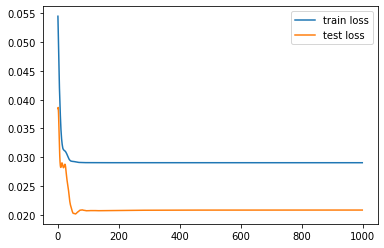

In [666]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

epochs = 1000
#seed=3
#torch.manual_seed(seed)
method = Linear(input_size=x_train.shape[1])
criterion = nn.MSELoss()
params_to_be_optimized = method.get_parameters()
optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
train_losses = []
test_losses = []

for epoch in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # forward pass
  y_train_predicted = method.predict(x_train)
  loss = criterion(y_train_predicted, y_train)

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()


  with torch.no_grad():

    y_train_predicted = method.predict(x_train)
    train_loss = criterion(y_train_predicted, y_train)
    train_losses.append(train_loss)

    y_test_predicted = method.predict(x_test)
    test_loss = criterion(y_test_predicted, y_test)
    test_losses.append(test_loss)

    if epoch%100==0:
      print(f'Epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}')

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# Test results

In [663]:
# Rescale test result to original values
zeros = np.zeros(x_test.shape)
test_predicted = np.concatenate((zeros, method.predict(x_test).detach().numpy()),axis=1)
test_predicted= scaler.inverse_transform(test_predicted)[:,-1]

test_target = np.concatenate((zeros, y_test.detach().numpy()),axis=1)
test_target = scaler.inverse_transform(test_target)[:,-1]

In [664]:
# Calculate percentage error
percentage_error = (test_target - test_predicted)/test_target

/tmp/ipykernel_218381/3495622638.py:2: RuntimeWarning: divide by zero encountered in true_divide
  percentage_error = (test_target - test_predicted)/test_target


ValueError: supplied range of [-inf, inf] is not finite

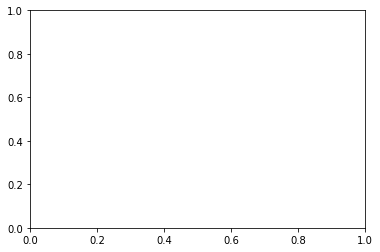

In [665]:
# Plot histogram of percentage error
plt.hist(percentage_error)
plt.show()